In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [2]:
create_experiment_snapshots([25, 50, 75, 100])

In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = 100
scheme = 'random'
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

def radar_plot(scheme,trial = 10, normalization_values = None):
    # Learning Parameters
    epsilon = 1.0  # exploration rate

    # Simulator Settings
    start_time = 0
    finish_time = 3000
    mtd_interval = 100
    total_nodes = 300
    new_network = True
    features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
    model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
    # Define the columns of the DataFrame
    security_metrics = pd.DataFrame(columns=features)
    for _ in range(trial):
        evaluation = execute_ai_model(model=model, features=features, start_time=start_time, finish_time=finish_time, mtd_interval=mtd_interval, scheme=scheme, total_nodes=total_nodes, new_network=new_network)
        security_metrics_trial = evaluation.security_metrics_record.get_record().drop('times', axis=1).iloc[-1]
        security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

    # Normalize each column using the normalization values if normalize=True
    if normalization_values:
        for column, norm_value in normalization_values.items():
            if column in security_metrics.columns:
                security_metrics[column] = security_metrics[column] / norm_value

    # Calculate median and standard deviation for each column
    results = {
        'Median': security_metrics.median(),
        'Standard Deviation': security_metrics.std()
    }

    # Convert to DataFrame for better readability
    results_security_metrics = pd.DataFrame(results).dropna()

    # Data from results_security_metrics DataFrame
    metrics_values = results_security_metrics['Median'].tolist()
    std_dev_values = results_security_metrics['Standard Deviation'].tolist()
    labels = results_security_metrics.index.tolist()

    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Repeat the first value to close the circle
    angles += angles[:1]
    metrics_values += metrics_values[:1]
    std_dev_values += std_dev_values[:1]
    labels += labels[:1]  # Close the circle by repeating the first label
    
    if normalization_values:
        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, metrics_values, color='blue', alpha=0.25)
        ax.plot(angles, metrics_values, color='blue', linewidth=2, label='Median')

        # Add error bars
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            error = std_dev_values[i]
            ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            # Position the text slightly away from the plotted point
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles)  # Set ticks without the last angle
        ax.set_xticklabels(labels, rotation=45, ha='right')

        plt.title(f"Radar chart with all 4 single MTD(compare to not using AI) over {trial} trials", size=15, color='blue', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()
    return {labels[i]: metrics_values[i] for i in range(len(labels))}


In [5]:
normalization_values = radar_plot(scheme,trial = 100)

2024-08-06 23:33:09.065158: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-06 23:33:09.065180: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-06 23:33:09.065186: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-06 23:33:09.065225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-06 23:33:09.065240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but 

In [6]:
normalization_values

{'host_compromise_ratio': 0.02,
 'exposed_endpoints': 5.0,
 'attack_path_exposure': 0.21932738095238097,
 'overall_asr_avg': 0.16743471582181257,
 'roa': 0.8719669242806176,
 'shortest_path_variability': 0.0,
 'risk': 2.326610883459216,
 'mtd_frequency': 0.008124752934918465,
 'overall_mtcc_avg': 1721.8971988726244,
 'time_since_last_mtd': 91.20034131232569}

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

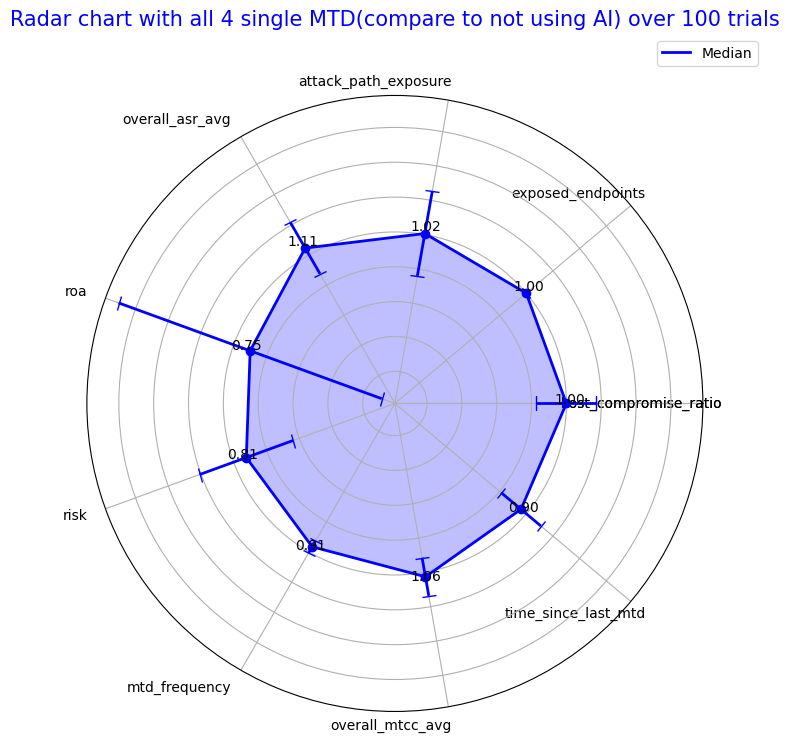

In [7]:
result = radar_plot(scheme='mtd_ai',trial = 100, normalization_values = normalization_values)

In [8]:
result

{'host_compromise_ratio': 1.0,
 'exposed_endpoints': 1.0,
 'attack_path_exposure': 1.015222104618799,
 'overall_asr_avg': 1.1135466097226616,
 'roa': 0.7487640985097554,
 'risk': 0.8077035191504516,
 'mtd_frequency': 0.9132407929859692,
 'overall_mtcc_avg': 1.0643235541543588,
 'time_since_last_mtd': 0.9013645310859818}